In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import math

import fastf1 as ff1
from fastf1 import plotting, utils
from datetime import timedelta

In [ ]:
# Enable the cache by providing the name of your cache folder
cache_path = '/file/path/to/local/cache'
ff1.Cache.enable_cache(cache_path)

In [3]:
# # Define target session
# grand_prix, session_type = 'Abu Dhabi', 'R'
# years = [2019, 2020, 2021, 2022, 2023]

# Define target session
year, grand_prix, session_type = 2023, 'Qatar', 'R'

# Define a color map for speed visualisations
colors = ["blue", "yellow", "red"]
speed_cmap = LinearSegmentedColormap.from_list("speed_cmap", colors)

In [4]:
angle_adjustments = {
    "Abu Dhabi": {
        16: -0.6,
        7: 0.0,
        "default": -0.3
    },
    "Las Vegas": {
        "default": -1.0
    },
    "Qatar": {
        6: 3.0,
        "default": -0.6
    }
    # Add more Grand Prix and specific corner adjustments as needed
}

track_angle_circuits = {
    "Abu Dhabi": (13*math.pi)/9,
    "Qatar": 61 * (math.pi / 180),
    "Las Vegas": 90 * (math.pi / 180)
}

events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INF

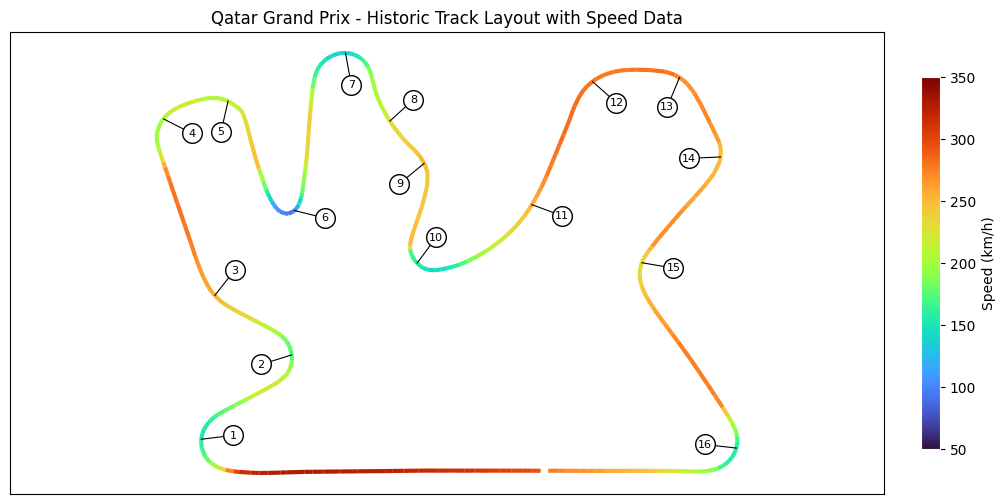

In [5]:
target_session = ff1.get_session(2023, grand_prix, session_type)
target_session.load(telemetry=True)

# Retrieve the fastest lap and position data
lap = target_session.laps.pick_fastest()
pos = lap.get_pos_data()

# print(lap)

circuit_session = ff1.get_session(2023, grand_prix, session_type)
circuit_session.load(telemetry=False)
circuit_info = circuit_session.get_circuit_info()

# Use the grand_prix name to fetch the relevant adjustments
grand_prix_adjustments = angle_adjustments.get(grand_prix, {})

# Define rotation and translation (adjust if needed)
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get the angle for the selected grand_prix, defaulting to 0 if not found
track_angle = track_angle_circuits.get(grand_prix, 0)

# Rotate the track layout based on the selected angle
track = pos[['X', 'Y']].to_numpy()
rotated_track = rotate(track, angle=track_angle)

# Plot the base track layout
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')  # Set figure background to black
ax.set_facecolor('white')  # Set axis background to black
plt.plot(rotated_track[:, 0], rotated_track[:, 1], color='gray', lw=0.5)

# Collect and rotate speed data along the track
speed_data = lap.get_car_data().add_distance()
speed = speed_data['Speed']
track_points = rotate(pos[['X', 'Y']].to_numpy(), angle=track_angle)

# Prepare segments for color-coded line
segments = np.concatenate([track_points[:-1], track_points[1:]], axis=1).reshape(-1, 2, 2)
line_collection = LineCollection(segments, cmap='turbo', norm=plt.Normalize(vmin=50, vmax=350))
line_collection.set_array(speed)
line_collection.set_linewidth(3)
ax.add_collection(line_collection)

# Color bar for speed values with black background
cbar = plt.colorbar(line_collection, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label("Speed (km/h)", color='black', fontsize=10)
cbar.outline.set_edgecolor('white')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Title and plot adjustments
plt.title(f"{grand_prix} Grand Prix - Historic Track Layout with Speed Data",
          color='black', fontsize=12)  # Set title color to white
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.axis('equal')  # Keep proportions

# Offset vector for corner labels (increase values for larger offset)
offset_vector = [500, 500]  # Adjust as needed to position corner labels further from the track

# Iterate over all corners and add labels
for _, corner in circuit_info.corners.iterrows():
    # Create the corner label text
    txt = f"{corner['Number']}{corner['Letter']}"

    # Fetch the specific adjustment for the corner if it exists, otherwise use the "default"
    angle_adjustment = grand_prix_adjustments.get(corner['Number'], grand_prix_adjustments.get("default", 0))

    # Apply the angle adjustment
    adjusted_offset_angle = corner['Angle'] / 180 * np.pi + angle_adjustment

    # Rotate the offset vector to align with the corner angle
    offset_x, offset_y = rotate(offset_vector, angle=adjusted_offset_angle)

    # Calculate text position by applying the offset
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text and corner positions according to the track angle
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)
    
    # Draw a line from the track to the label circle
    plt.plot([track_x, text_x], [track_y, text_y], color='black', lw=0.8, zorder=3)

    # Draw a larger circle for each corner
    plt.scatter(text_x, text_y, color='white', s=200, edgecolor='black', zorder=3)

    # Add the corner label text with more contrast
    plt.text(text_x, text_y, txt, va='center', ha='center', fontsize=8, color='black', zorder=6)  # Adjusted fontsize for better readability

# Save plot
file_name = '../visualisations/Qatar_TrackSpeed.png'
plt.savefig(file_name, dpi=300)  # bbox_inches='tight'

# Display the plot
plt.show()

events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INF

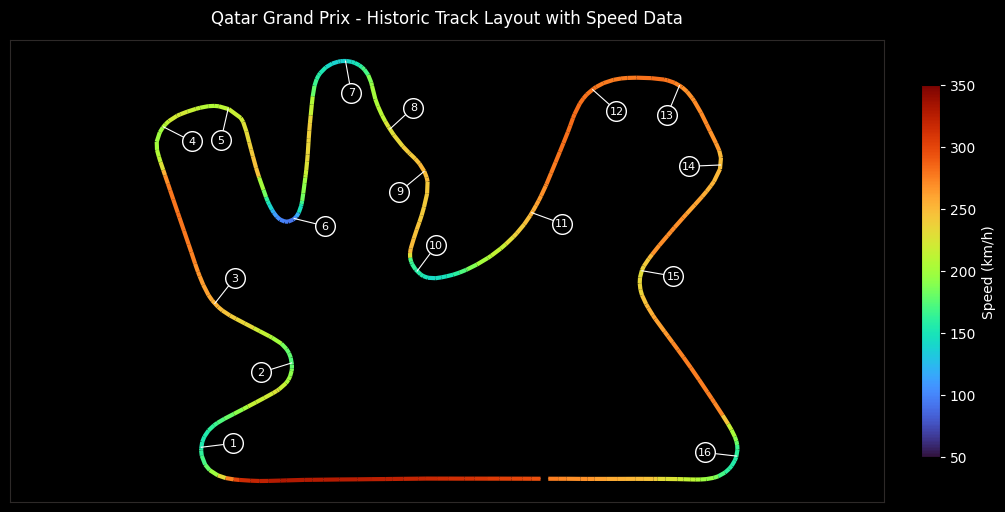

In [6]:
# Load FastF1's dark color scheme
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')

target_session = ff1.get_session(2023, grand_prix, session_type)
target_session.load(telemetry=True)

# Retrieve the fastest lap and position data
lap = target_session.laps.pick_fastest()
pos = lap.get_pos_data()

# print(lap)

circuit_session = ff1.get_session(2023, grand_prix, session_type)
circuit_session.load(telemetry=False)
circuit_info = circuit_session.get_circuit_info()

# Use the grand_prix name to fetch the relevant adjustments
grand_prix_adjustments = angle_adjustments.get(grand_prix, {})

# Define rotation and translation (adjust if needed)
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get the angle for the selected grand_prix, defaulting to 0 if not found
track_angle = track_angle_circuits.get(grand_prix, 0)

# Rotate the track layout based on the selected angle
track = pos[['X', 'Y']].to_numpy()
rotated_track = rotate(track, angle=track_angle)

# Plot the base track layout
fig, ax = plt.subplots(figsize=(12, 6), facecolor='black')  # Set figure background to black
ax.set_facecolor('black')  # Set axis background to black
plt.plot(rotated_track[:, 0], rotated_track[:, 1], color='gray', lw=0.5)

# Collect and rotate speed data along the track
speed_data = lap.get_car_data().add_distance()
speed = speed_data['Speed']
track_points = rotate(pos[['X', 'Y']].to_numpy(), angle=track_angle)

# Prepare segments for color-coded line
segments = np.concatenate([track_points[:-1], track_points[1:]], axis=1).reshape(-1, 2, 2)
line_collection = LineCollection(segments, cmap='turbo', norm=plt.Normalize(vmin=50, vmax=350))
line_collection.set_array(speed)
line_collection.set_linewidth(3)
ax.add_collection(line_collection)

# Color bar for speed values with black background
cbar = plt.colorbar(line_collection, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label("Speed (km/h)", color='white', fontsize=10)
cbar.outline.set_edgecolor('black')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Title and plot adjustments
plt.title(f"{grand_prix} Grand Prix - Historic Track Layout with Speed Data",
          color='white', fontsize=12)  # Set title color to white
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.axis('equal')  # Keep proportions

# Offset vector for corner labels (increase values for larger offset)
offset_vector = [500, 500]  # Adjust as needed to position corner labels further from the track

# Iterate over all corners and add labels
for _, corner in circuit_info.corners.iterrows():
    # Create the corner label text
    txt = f"{corner['Number']}{corner['Letter']}"

    # Fetch the specific adjustment for the corner if it exists, otherwise use the "default"
    angle_adjustment = grand_prix_adjustments.get(corner['Number'], grand_prix_adjustments.get("default", 0))

    # Apply the angle adjustment
    adjusted_offset_angle = corner['Angle'] / 180 * np.pi + angle_adjustment

    # Rotate the offset vector to align with the corner angle
    offset_x, offset_y = rotate(offset_vector, angle=adjusted_offset_angle)

    # Calculate text position by applying the offset
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text and corner positions according to the track angle
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)
    
    # Draw a line from the track to the label circle
    plt.plot([track_x, text_x], [track_y, text_y], color='white', lw=0.8, zorder=3)

    # Draw a larger circle for each corner
    plt.scatter(text_x, text_y, color='black', s=200, edgecolor='white', zorder=3)

    # Add the corner label text with more contrast
    plt.text(text_x, text_y, txt, va='center', ha='center', fontsize=8, color='white', zorder=6)  # Adjusted fontsize for better readability

# Uncomment to Save plot
# file_name = '../visualisations/LasVegas_TrackSpeed.png'
# plt.savefig(file_name, dpi=300)  # bbox_inches='tight'

# Display the plot
plt.show()

In [7]:
# # Define a helper function to calculate cumulative distance
# def calculate_distance(pos_df):
#     # Calculate the distance between consecutive points
#     pos_df['Distance'] = np.sqrt((pos_df['X'].diff())**2 + (pos_df['Y'].diff())**2).cumsum()
#     pos_df['Distance'].fillna(0, inplace=True)  # Fill the first NaN with 0
#     return pos_df

In [8]:
# # Track whether the GP has been found in any specified year
# found_in_specified_years = False

# # Initialise an empty df to store all telemetry data across years
# all_years_telemetry_df = pd.DataFrame()

# # Load session data if available for each specified year
# for year in years:
#     # Get the event schedule for the year
#     schedule = ff1.get_event_schedule(year)
    
#     # Session name to event schedule format
#     gp_eventname = grand_prix + ' Grand Prix'
    
#     # Check if the specified Grand Prix is in the schedule
#     if gp_eventname in schedule['EventName'].values:
#         try:
#             print(f'Processing: {gp_eventname} {year}')
#             # Load the session with telemetry data
#             target_session = ff1.get_session(year, grand_prix, session_type)
#             target_session.load(telemetry=True)
            
#             # Filter for the top 10 finishers
#             top_finishers = target_session.results[:10]

#             # Now load telemetry for the fastest lap of each top 10 finisher
#             for driver in top_finishers['Abbreviation']:
#                 # Select only the fastest lap for the driver
#                 fastest_lap = target_session.laps.pick_driver(driver).pick_fastest()
                
#                 # Get telemetry data with distance
#                 telemetry = fastest_lap.get_car_data().add_distance()  # Adds 'Distance' to telemetry data
                
#                 # Get positional data and calculate Distance if missing
#                 pos_data = fastest_lap.get_pos_data()[['X', 'Y']]  # Get only 'X' and 'Y'
#                 pos_data = calculate_distance(pos_data)  # Calculate cumulative Distance
                
#                 # Print pos_data to verify it contains 'Distance', 'X', and 'Y'
#                 print(f"\nDriver: {driver}")
#                 print(pos_data.head())  # Print first few rows for verification
                
#                 # Merge telemetry and positional data on Distance to add X and Y coordinates
#                 telemetry = pd.merge_asof(
#                     telemetry.sort_values('Distance'),
#                     pos_data.sort_values('Distance'),
#                     on='Distance',
#                     direction='nearest'
#                 )
                
#                 # Add metadata for the driver and year
#                 telemetry['Driver'] = driver
#                 telemetry['Year'] = year
#                 all_years_telemetry_df = pd.concat([all_years_telemetry_df, telemetry])

#             print(f'{gp_eventname} {year} data processed.')
#             found_in_specified_years = True

#         except Exception as e:
#             print(f'Error loading data for {gp_eventname} {year}: {e}')
#     else:
#         print(f'{gp_eventname} not found in {year}, skipping.')

In [9]:
# # Define a standard distance grid (e.g., every 10 meters)
# standard_distance = np.linspace(0, all_years_telemetry_df['Distance'].max(), num=340)  # Adjust num for desired resolution

# # Initialize lists to store interpolated data
# all_drivers_interpolated = []

# # Interpolate each driver’s data to match the standard distance grid
# for driver in all_years_telemetry_df['Driver'].unique():
#     driver_data = all_years_telemetry_df[all_years_telemetry_df['Driver'] == driver]
    
#     # Interpolators for X, Y, and Speed based on the driver's Distance
#     interp_x = interp1d(driver_data['Distance'], driver_data['X'], kind='linear', bounds_error=False, fill_value="extrapolate")
#     interp_y = interp1d(driver_data['Distance'], driver_data['Y'], kind='linear', bounds_error=False, fill_value="extrapolate")
#     interp_speed = interp1d(driver_data['Distance'], driver_data['Speed'], kind='linear', bounds_error=False, fill_value="extrapolate")
    
#     # Apply interpolation to the standard distance grid
#     interpolated_x = interp_x(standard_distance)
#     interpolated_y = interp_y(standard_distance)
#     interpolated_speed = interp_speed(standard_distance)
    
#     # Store the interpolated data in a DataFrame
#     interpolated_df = pd.DataFrame({
#         'Distance': standard_distance,
#         'X': interpolated_x,
#         'Y': interpolated_y,
#         'Speed': interpolated_speed,
#         'Driver': driver
#     })
    
#     # Append the interpolated DataFrame to the list
#     all_drivers_interpolated.append(interpolated_df)

# # Combine all interpolated driver data
# interpolated_data = pd.concat(all_drivers_interpolated, ignore_index=True)

# # Calculate the mean X, Y, and Speed at each standardized Distance
# mean_speed_by_distance = interpolated_data.groupby('Distance')[['X', 'Y', 'Speed']].mean().reset_index()

In [10]:
# # Check and display all gathered telemetry data for debugging
# print(mean_speed_by_distance.columns)
# mean_speed_by_distance

In [11]:
# # Define rotation and translation (adjust if needed)
# def rotate(xy, *, angle):
#     rot_mat = np.array([[np.cos(angle), np.sin(angle)],
#                         [-np.sin(angle), np.cos(angle)]])
#     return np.matmul(xy, rot_mat)

# # Rotate the track layout manually if desired (default angle set to 0 here)
# track = mean_speed_by_distance[['X', 'Y']].to_numpy()
# track_angle = 0  # Manually enter rotation of track if desired, in future: rotation dict
# rotated_track = rotate(track, angle=track_angle)

# # Plot the base track layout
# fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
# plt.plot(rotated_track[:, 0], rotated_track[:, 1], color='gray', lw=0.5)

# # Collect and rotate speed data along the track
# speed = mean_speed_by_distance['Speed']
# track_points = rotate(mean_speed_by_distance[['X', 'Y']].to_numpy(), angle=track_angle)

# # Prepare segments for color-coded line
# segments = np.concatenate([track_points[:-1], track_points[1:]], axis=1).reshape(-1, 2, 2)
# line_collection = LineCollection(segments, cmap='turbo', norm=plt.Normalize(vmin=speed.min(), vmax=speed.max()))
# line_collection.set_array(speed)
# line_collection.set_linewidth(3)
# ax.add_collection(line_collection)

# # Color bar for speed values
# cbar = plt.colorbar(line_collection, ax=ax)
# cbar.set_label("Speed (km/h)")

# # Title and plot adjustments
# plt.title(f"{year} | {grand_prix} | {target_session.event['Location']} | Track Layout with Speed Data")
# plt.xticks([])
# plt.yticks([])
# plt.axis('equal')
# plt.show()

In [12]:
# # If the Grand Prix wasn't found in the specified years, search across a wider range of years
# if not found_in_specified_years:
#     print(f'{gp_eventname} not found in the specified years. Checking historical schedules...')

#     # Define the range for historical search (adjustable)
#     historic_years = range(2000, 2019)  # Check for availability in previous years
#     available_years = []

#     for hist_year in historic_years:
#         schedule = ff1.get_event_schedule(hist_year)
        
#         if gp_eventname in schedule['EventName'].values:
#             available_years.append(hist_year)

#     # Provide user feedback based on historical data availability just adjust years list if desired
#     if available_years:
#         print(f"{gp_eventname} data was found for years: {available_years}")
#     else:
#         print(f"No historic data for {gp_eventname} in the selected session.")